# Chapter 11. 심층 신경망 훈련

복잡한 문제 해결을 위한 깊은 심층 신경망 훈련의 문제
1. Gradients 문제 - Vanishing Gradients / Exploding Gradients
2. 극단적으로 느린 학습 속도
3. Overfitting

In [42]:
# 파이썬 2와 파이썬 3 지원
from __future__ import division, print_function, unicode_literals

# 공통
import numpy as np
import os

# 일관된 출력을 위해 유사난수 초기화
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# 맷플롯립 설정
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
def get_osx_hangul_font():
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    import matplotlib.font_manager as fm

    print ('설정파일 위치: ', mpl.matplotlib_fname())
    # OSX 의 설치 된 폰트를 가져오는 함수
    font_list_mac = fm.OSXInstalledFonts()

    nanum_fonts = [(f.name, f.fname) for f in fm.fontManager.ttflist if 'Myungjo' in f.name]
    print(nanum_fonts)
plt.rcParams["font.family"] = 'AppleMyungjo'
# plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['axes.unicode_minus'] = False

# 그림을 저장할 폴더
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

## 11.1 그래디언트 소실과 폭주 문제

역전파 알고리즘(backpropagation algorithm)
- 출력층에서 입력층으로 오차 그래디언트를 전파시키면서 진행
- 알고리즘이 모든 파라미터에 대한 오차 함수의 그래디언트를 계산하면 Gradients Descent 단계에서 이 그래디언트를 이용하여 파라미터를 갱신함
- 알고리즘이 하위층으로 진행됨에 따라 그래디언트는 점점 작아지는 경우가 많음: **Vanishing Gradients**
![Vanishing Gradient](https://t1.daumcdn.net/cfile/tistory/2738F43B583AC4C933)
- 반대로 그래디언트가 점점 커져 여러개의 층이 비정상적으로 큰 가중치로 갱신되어 발산: **Exploding Gradients** (RNN 에서 주로 나타남)

##### Understanding the difficulty of training deep feedforward neural networks
> Glorot, Xavier, and Yoshua Bengio. "**Understanding the difficulty of training deep feedforward neural networks.**" In Proceedings of the thirteenth international conference on artificial intelligence and statistics, pp. 249-256. 2010.

- 로지스틱 시그모이드 활성화 함수
- 가중치 초기화 방법
  - 평균이 0, 표준편차가 1인 정규분포를 사용한 무작위 초기화
- 이 조합으로 학습했을 때, **출력**의 분산이 **입력**의 분산보다 더 큼
- 신경망의 위쪽으로 갈수록 분산이 계속 커져 가장 높은층에서는 Activation Function 이 **0이나 1**로 수렴함
![LogisticActivation](images/deep/sigmoid_saturation_plot.png)
    - 로지스틱 함수의 **평균**이 0이 아니라 **0.5**
    - 하이퍼볼릭 탄젠트는 평균이 0이므로 조금 더 나음
    - 입력의 절대값이 크면 0이나 1로 수렴 => 기울기가 0에 매우 가까움 => backpropagation 시 propagate 할 그래디언트가 거의 없고, 최상위층부터 backpropagate 되면서 점차 약해져 실제로 아래쪽 층에는 아무것도 도달하지 않음
    - 로지스틱 함수의 도함수는 $\sigma(1-\sigma)$ 이므로, 함수의 값이 0이나 1에 가까우면 도함수의 결과가 매우 작아지고, 층이 거듭될수록 그 값이 더 작아짐
    

평균:  0.5000000000000002


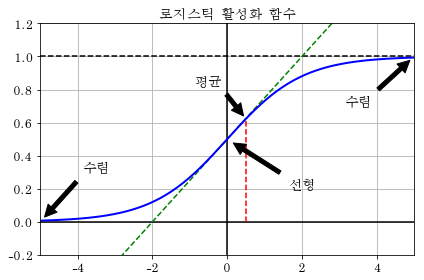

In [53]:
def logit(z):
    return 1 / (1 + np.exp(-z))

z = np.linspace(-5, 5, 200)
logit_z = logit(z)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)

props = dict(facecolor='black', shrink=0.1)
plt.annotate('수렴', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('수렴', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('선형', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")

# print mean
mean = sum(logit_z) / len(logit_z)
print('평균: ', mean)
plt.plot([mean, mean], [0, logit(mean)], 'r--')
plt.annotate('평균', xytext=(mean-1, logit(mean+1)), xy=(mean,logit(mean)), arrowprops=props, fontsize=14, ha="center")

plt.grid(True)
plt.title("로지스틱 활성화 함수", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("sigmoid_saturation_plot")
plt.show()

### 11.1.1 Xavier 초기화와 He 초기화

- 예측을 할 때는 정방향으로,<br/>
역전파할 때는 역방향으로 신호가 적절하게 흘러야 함
- 신호가 죽거나 폭주/소멸하지 않아야 함
- **각 층의 출력에 대한 분산이 입력에 대한 분산과 동일해야 함!**

----
**식 11-1: Xavier 초기화 (로지스틱 활성화 함수를 사용했을 때)**

> $
\begin{split}
& \text{평균이 0이고 표준 편차 }
\sigma = \sqrt{\dfrac{2}{n_\text{inputs} + n_\text{outputs}}} \text{ 인 정규분포}\\
& \text{또는 }
r = \sqrt{\dfrac{6}{n_\text{inputs} + n_\text{outputs}}} \text{ 일 때 } -r \text{ 과 } +r \text{ 사이의 균등분포}
\end{split}
$

단, $n_\text{inputs}$와 $n_\text{outputs}$는 가중치를 초기화하려는 층의 입력/출력 연결의 개수 (fan-in/out)

----

**입력의 개수와 출력의 개수가 비슷하면($n_\text{inputs} \approx n_\text{outputs}$) 더 간단한 공식 사용 가능**

> 예를 들면, $ \sigma = \dfrac{1}{\sqrt{n_\text{inputs}}} $ 또는 $ r = \dfrac{\sqrt{3}}{\sqrt{n_\text{inputs}}} $

----

**He initialization**: ReLU 활성화 함수 및 변종들을 위한 초기화 variance_scaling_initializer전략

----

**표 11-1: 활성화 함수 종류에 따른 초기화 매개변수**

| Activation Func. | Uniform Distribution________ | Normal Distribution________ |
|--------------|-------------------|-----------------------------------|
| Logistic | $ r = \sqrt{\dfrac{6}{n_\text{inputs} + n_\text{outputs}}} $ | $ \sigma = \sqrt{\dfrac{2}{n_\text{inputs} + n_\text{outputs}}} $ |
| Hyperbolic tangent | $ r = 4 \sqrt{\dfrac{6}{n_\text{inputs} + n_\text{outputs}}} $ | $ \sigma = 4 \sqrt{\dfrac{2}{n_\text{inputs} + n_\text{outputs}}} $ |
| ReLU (and its variants) |$ r = \sqrt{2} \sqrt{\dfrac{6}{n_\text{inputs} + n_\text{outputs}}} $ | $ \sigma = \sqrt{2} \sqrt{\dfrac{2}{n_\text{inputs} + n_\text{outputs}}} $|

`tf.layer.dense()` 함수는 기본적으로 **Xavier 초기화(with uniform distribution)** 을 사용함 이를 `tf.variance_scaling_initializer()` 함수를 이용하여 아래와 같이 변경 가능
>```
he_init = tf.variance_scaling_initializer()
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                          kernel_initializer=he_init, name="hidden1")
```

In [54]:
import tensorflow as tf

/Users/jonghoon.seo/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/Users/jonghoon.seo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [60]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

he_init = tf.variance_scaling_initializer()
# ReLU 활성화 함수, He 초기화
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                          kernel_initializer=he_init, name="hidden1")

### 11.1.2 수렴하지 않는 활성화 함수 (Nonsaturating Activation Functions)

- (Glorot & Bengio, 2010)의 insight 중 하나는, "**활성화 함수를 잘못 선택하면 그래디언트의 소실이나 폭주로 이어질 수 있다**"는 것
  - 그 전에는 생물학적 뉴런과 유사한 Sigmoid 함수가 최선의 선택일 것이라고 추측
- ReLU
  - 특정 양숫값에 수렴하지 않을 뿐 아니라, 계산도 빠르다는 장점
  - 하지만... *dying ReLUs problem*
    - 훈련하는 동안 일부 뉴런이 0 이외의 값을 출력하지 않음
    - 큰 학습률을 사용하면 뉴런 절반이 죽어있기도 함
    - 학습 도중 가중치가 바뀌어 가중치 합이 음수가 되면, 그 다음부터는 0을 출력함 - 다시 살아나지 못함...
- **LeakyReLU(새는 ReLU)**
  - dying ReLUs 문제 해결
  - $LeakyReLU_\alpha(z) = max(\alpha z,z)$
  ![LeakyReLU](images/deep/leaky_relu_plot.png)
  - $\alpha$
    - 새는 정도(how much the function 'leaks')를 나타냄
    - $z<0$일 때 이 함수의 기울기
    - 일반적으로 $0.01$ <br/>
      $0.2$ 가 더 나은 성능을 내는 것으로 보임
    - ReLU가 절대 죽지 않고 다시 깨어날 가능성 부여
  - (Xu, Wang, Chen, & Li, 2015)
    - **LeakyReLU 가 항상 ReLU보다 성능이 높음**
    - RReLU (Randomized leaky ReLU)
      - 학습 시에는 범위 내에서 $\alpha$를 무작위로 선택하고, 테스트 시에는 평균 사용
      - 잘 동작했으며, overfitting 을 줄이는 Regulation 의 역할
    - PReLU (Parametric leaky ReLU)
      - 훈련 동안 $\alpha$가 학습됨 (하이퍼파라미터가 아니라 역전파에 의해 변경됨)
      - 대규모 이미지 데이터셋에서는 ReLU보다 성능이 앞서지만, 소규모 데이터셋에서는 overfitting 될 위험
          

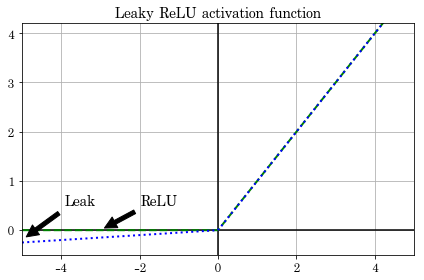

In [79]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.plot(z, leaky_relu(z, 0), "g--", linewidth=2)
plt.plot(z, leaky_relu(z, 0.05), "b:", linewidth=2)
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('ReLU', xytext=(-1.5, 0.5), xy=(-3, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

save_fig("leaky_relu_plot")
plt.show()

#### Leaky ReLU를 이용한 tensorflow 학습

In [85]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

# define network
with tf.name_scope("dnn"):
    # 28*28 -> 300 (leaky_relu)
    hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")
    # 300 -> 100 (leaky_relu)
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=leaky_relu, name="hidden2")
    # 100 -> 10
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

# loss
# https://tensorflowkorea.gitbooks.io/tensorflow-kr/content/g3doc/tutorials/mnist/tf/
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    
learning_rate = 0.01

# train
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    
# evaluation
with tf.name_scope("eval"):
    # in_top_k(predictions, targets, k, name=None): Says whether the targets are in the top K predictions.
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

데이터 로드:

주의: `tf.examples.tutorials.mnist`은 삭제될 예정이므로 대신 `tf.keras.datasets.mnist`를 사용하겠습니다.

In [86]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

11460608/11490434 [============================>.] - ETA: 0s

In [87]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch
        
n_epochs = 40
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 5 == 0:
            acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
            acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
            print(epoch, "배치 데이터 정확도:", acc_batch, "검증 세트 정확도:", acc_valid)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 배치 데이터 정확도: 0.86 검증 세트 정확도: 0.9046
5 배치 데이터 정확도: 0.94 검증 세트 정확도: 0.9496
10 배치 데이터 정확도: 0.92 검증 세트 정확도: 0.9654
15 배치 데이터 정확도: 0.94 검증 세트 정확도: 0.9708
20 배치 데이터 정확도: 1.0 검증 세트 정확도: 0.9764
25 배치 데이터 정확도: 1.0 검증 세트 정확도: 0.9774
30 배치 데이터 정확도: 0.98 검증 세트 정확도: 0.978
35 배치 데이터 정확도: 1.0 검증 세트 정확도: 0.9784


**ELU (Exponential Linear Unit)**
- (Clevert, Unterthiner, & Hochreiter, 2015)
- 다른 모든 ReLU 변종의 성능을 앞지름
- 학습 시간 감소
- **식 11-2: ELU 활성화 함수**
>$
\operatorname{ELU}_\alpha(z) =
\begin{cases}
\alpha(\exp(z) - 1) & z < 0 \text{ 일 때}\\
z & z \ge 0 \text{ 일 때}
\end{cases}
$

### References

(Clevert, Unterthiner, & Hochreiter, 2015) Clevert, D.-A., Unterthiner, T., & Hochreiter, S. (2015). Fast and Accurate Deep Network Learning by Exponential Linear Units (ELUs). ArXiv:1511.07289 [Cs]. Retrieved from http://arxiv.org/abs/1511.07289

(Glorot & Bengio, 2010) Glorot, X., & Bengio, Y. (2010). Understanding the difficulty of training deep feedforward neural networks. In In Proceedings of the International Conference on Artificial Intelligence and Statistics (AISTATS’10). Society for Artificial Intelligence and Statistics.

(Xu, Wang, Chen, & Li, 2015) Xu, B., Wang, N., Chen, T., & Li, M. (2015). Empirical Evaluation of Rectified Activations in Convolutional Network. ArXiv:1505.00853 [Cs, Stat]. Retrieved from http://arxiv.org/abs/1505.00853


https://pozalabs.github.io/Activation_Function/
